In [70]:
# ===============================
# Diabetes Risk/Protective Factor Analysis - Jupyter Notebook
# Portfolio-Ready Version
# ===============================

# ===============================
# Cell 1: Import Libraries
# ===============================
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid")


# Diabetes Risk Analysis

This project analyzes the BRFSS 2015 dataset to identify **risk and protective factors for diabetes**, compute a **RiskScore** for each individual, and highlight the **most at-risk individuals**. The analysis also explores **income groups** and their relationship to diabetes risk.


In [71]:
# ===============================
# Cell 2: Load Dataset
# ===============================
file_path = r"data/diabetes_012_health_indicators_BRFSS2015.csv"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found at {file_path}")

df = pd.read_csv(file_path)
print(f"Dataset loaded: {df.shape} rows, {df.shape[1]} columns")
df.head()


Dataset loaded: (253680, 22) rows, 22 columns


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


## Step 1: Correlation Matrix

I calculated correlations between each feature and the diabetes outcome (`Diabetes_012`) to identify **risk and protective factors**.  
Direct Health conditions show the strongest link to Diabetes, diet and life style are important but play a more subtle role.   

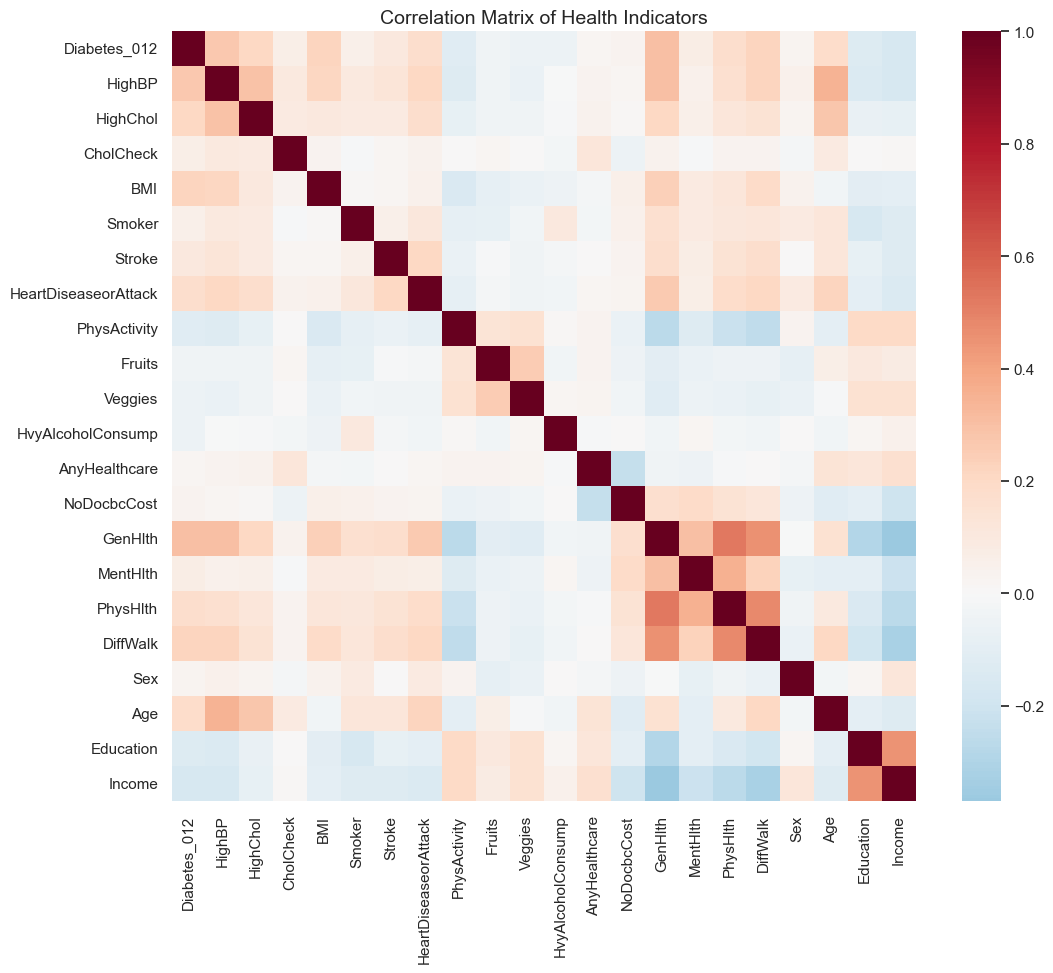

In [72]:
# ===============================
# Cell 3: Correlation Matrix
# ===============================
corr = df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="RdBu_r", center=0)
plt.title("Correlation Matrix of Health Indicators", fontsize=14)
plt.savefig("images/correlation_matrix.png", bbox_inches='tight')
plt.show()



Direct health conditions show the strongest link to diabetes, while diet and lifestyle are important but play a more subtle role. For instance, fruit and vegetable consumption, though universally regarded as important, appears to have less of a positive effect than income. This may be because reported intake of fruit and vegetables is more subjective than some of the other health-related questions.

## Step 2: Identify Risk and Protective Factors
- **Risk factors**: positively correlated with diabetes  
- **Protective factors**: negatively correlated with diabetes


In [73]:
# ===============================
# Cell 4: Risk and Protective Factors
# ===============================
target = 'Diabetes_012'
correlations = corr[target].drop(target).sort_values()

risk_factors = correlations[correlations > 0].index.tolist()
protective_factors = correlations[correlations < 0].index.tolist()

# Display as a table
risk_table = pd.DataFrame({"Risk Factors": risk_factors})
protective_table = pd.DataFrame({"Protective Factors": protective_factors})

display(risk_table)
display(protective_table)


,Risk Factors
0,AnyHealthcare
1,Sex
2,NoDocbcCost
3,Smoker
4,CholCheck
5,MentHlth
6,Stroke
7,PhysHlth
8,HeartDiseaseorAttack
9,Age


,Protective Factors
0,Income
1,Education
2,PhysActivity
3,Veggies
4,HvyAlcoholConsump
5,Fruits


,Diabetes Status,Heavy Alcohol Consumers (%)
0,0.00,6.18
1,1.00,4.49
2,2.00,2.35


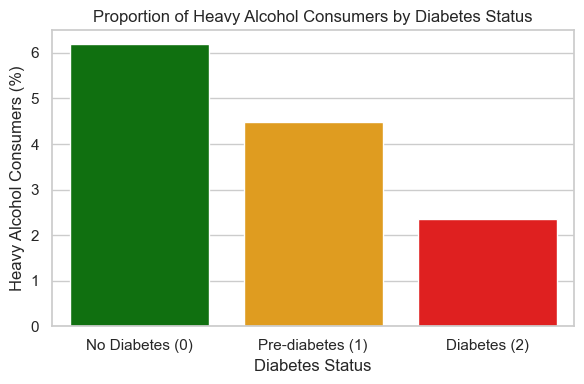

,Non-Heavy Drinker (%),Heavy Drinker (%)
IncomeGroup,,
Low,95.97,4.03
Medium,94.31,5.69
High,92.97,7.03


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-4.7889,0.0423,-113.2864,0.0000,-4.8718,-4.7061
HvyAlcoholConsump,-0.6293,0.0339,-18.5790,0.0000,-0.6956,-0.5629
Age,0.2019,0.0022,90.4518,0.0000,0.1975,0.2063
Income,-0.1504,0.0027,-55.5110,0.0000,-0.1557,-0.1451
PhysActivity,-0.3000,0.0127,-23.6409,0.0000,-0.3249,-0.2752
BMI,0.0838,0.0009,98.3574,0.0000,0.0821,0.0855



=== Stratified by Income Group ===

Income Group: Low
Diabetes_012
0.0    4.71
1.0    3.28
2.0    1.67
Name: HvyAlcoholConsump, dtype: float64

Income Group: High
Diabetes_012
0.0    7.35
1.0    5.44
2.0    3.50
Name: HvyAlcoholConsump, dtype: float64

Income Group: Medium
Diabetes_012
0.0    6.16
1.0    5.60
2.0    2.71
Name: HvyAlcoholConsump, dtype: float64

=== Stratified by Age Group ===

Age Group: (8.0, 10.0]
Diabetes_012
0.0    6.44
1.0    4.15
2.0    2.19
Name: HvyAlcoholConsump, dtype: float64

Age Group: (6.0, 8.0]
Diabetes_012
0.0    6.94
1.0    5.89
2.0    2.80
Name: HvyAlcoholConsump, dtype: float64

Age Group: (10.0, 13.0]
Diabetes_012
0.0    4.75
1.0    3.87
2.0    1.68
Name: HvyAlcoholConsump, dtype: float64

Age Group: (0.999, 6.0]
Diabetes_012
0.0    6.36
1.0    4.58
2.0    4.02
Name: HvyAlcoholConsump, dtype: float64


In [74]:
# ===============================
# Investigation: Heavy Alcohol Consumption & Diabetes
# ===============================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 0. Create IncomeGroup if missing (quartiles)
if 'Income' in df.columns and 'IncomeGroup' not in df.columns:
    income_groups = pd.qcut(df['Income'], q=4, duplicates='drop')
    n_groups = income_groups.cat.categories.size
    labels = ['Low', 'Medium', 'High', 'Very High'][:n_groups]
    df['IncomeGroup'] = income_groups.cat.rename_categories(labels)

# 1. Proportion of heavy drinkers by diabetes status
alcohol_prop = (
    df.groupby(target)['HvyAlcoholConsump']
      .mean()
      .reset_index()
      .rename(columns={target: 'Diabetes Status', 'HvyAlcoholConsump': 'Heavy Alcohol Consumers (%)'})
)
alcohol_prop['Heavy Alcohol Consumers (%)'] *= 100

# Display table
display(
    alcohol_prop.style
        .set_caption("Heavy Alcohol Consumption by Diabetes Status (%)")
        .format(precision=2)
        .background_gradient(cmap='Oranges')
)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(
    data=alcohol_prop,
    x='Diabetes Status',
    y='Heavy Alcohol Consumers (%)',
    palette=['green', 'orange', 'red'],
    errorbar=None
)
plt.title("Proportion of Heavy Alcohol Consumers by Diabetes Status")
plt.xlabel("Diabetes Status")
plt.ylabel("Heavy Alcohol Consumers (%)")
plt.xticks([0, 1, 2], ["No Diabetes (0)", "Pre-diabetes (1)", "Diabetes (2)"])
plt.tight_layout()
plt.savefig("images/heavy_alcohol_by_status.png", dpi=300, bbox_inches='tight')
plt.show()
alcohol_prop.to_csv("data/heavy_alcohol_by_status.csv", index=False)
# 2. Cross-tab with IncomeGroup
if 'IncomeGroup' in df.columns:
    alcohol_income = pd.crosstab(df['IncomeGroup'], df['HvyAlcoholConsump'], normalize='index') * 100
    alcohol_income.columns = ['Non-Heavy Drinker (%)', 'Heavy Drinker (%)']
    display(
        alcohol_income.style
            .set_caption("Heavy Alcohol Consumption by Income Group (%)")
            .format(precision=2)
            .background_gradient(cmap='Blues')
    )

# ============================================
# 3. Adjusted Association: Logistic Regression
# ============================================

# Create binary diabetes outcome
df['DiabetesBinary'] = (df[target] > 0).astype(int)

# Select covariates
covariates = ['HvyAlcoholConsump', 'Age', 'Income', 'PhysActivity', 'BMI']
covariates = [c for c in covariates if c in df.columns]

# Build model
X = sm.add_constant(df[covariates])
y = df['DiabetesBinary']
model = sm.Logit(y, X).fit(disp=False)

# Extract and style regression table
regression_table = model.summary2().tables[1]
styled_output = (
    regression_table.style
        .set_caption("Logistic Regression: Diabetes vs Heavy Alcohol (Adjusted)")
        .format(precision=4)
        .background_gradient(cmap='Reds', subset=['Coef.'] if 'Coef.' in regression_table.columns else None)
)
display(styled_output)

# 4. Stratified analysis by IncomeGroup
if 'IncomeGroup' in df.columns:
    print("\n=== Stratified by Income Group ===")
    for group in df['IncomeGroup'].unique():
        sub = df[df['IncomeGroup'] == group]
        if sub.empty:
            continue
        prop = sub.groupby(target)['HvyAlcoholConsump'].mean() * 100
        print(f"\nIncome Group: {group}")
        print(prop.round(2))

# 5. Stratified analysis by Age Group (quartiles)
if 'Age' in df.columns:
    df['AgeGroup'] = pd.qcut(df['Age'], q=4, duplicates='drop')
    print("\n=== Stratified by Age Group ===")
    for group in df['AgeGroup'].unique():
        sub = df[df['AgeGroup'] == group]
        if sub.empty:
            continue
        prop = sub.groupby(target)['HvyAlcoholConsump'].mean() * 100
        print(f"\nAge Group: {group}")
        print(prop.round(2))

Heavy drinking appears lowest among people with diabetes in this dataset, which may reflect behaviour change or under‑reporting after diagnosis rather than a true protective effect — further analysis is needed to confirm.

Visual Analysis of Most Common Risk Factors
# 
# This section provides comprehensive visualizations of the risk factors identified in my analysis.


## Step 3: Compute RiskScore

Since the dataset contains features with different ranges, I used StandardScaler to put them on the same scale and then computed a RiskScore as:

RiskScore = sum of standardized risk factors − sum of standardized protective factors.”**


In [75]:
# ===============================
# Cell 5: Standardize Features & Compute RiskScore + RiskLevel
# ===============================

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# 1. Standardize all risk and protective factors
scaler = StandardScaler()
scaled = pd.DataFrame(
    scaler.fit_transform(df[risk_factors + protective_factors]),
    columns=risk_factors + protective_factors
)

# 2. Compute raw RiskScore
df['RiskScore'] = (
    scaled[risk_factors].sum(axis=1)
    - scaled[protective_factors].sum(axis=1)
)

# 3. Define quantile thresholds for categories
q_low  = df['RiskScore'].quantile(0.50)   # medium cutoff (50th percentile)
q_high = df['RiskScore'].quantile(0.90)   # high-risk cutoff (90th percentile)

# 4. Assign Low/Medium/High risk levels
df['RiskLevel'] = pd.cut(
    df['RiskScore'],
    bins=[-np.inf, q_low, q_high, np.inf],
    labels=['Low', 'Medium', 'High']
)

# 5. (Optional) Quick check of category counts
display(df['RiskLevel'].value_counts())


RiskLevel
Low       126840
Medium    101472
High       25368
Name: count, dtype: int64

Most people in the dataset fall into the low to moderate risk category. However, a significant number are in the moderate risk group, and while fewer in number, there are unfortunately some individuals in the high-risk group, whom I will later identify for further intervention.

## Step 4: Average RiskScore by Diabetes Status


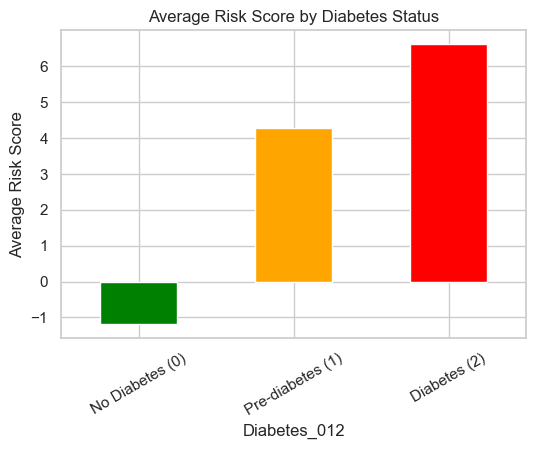

,Diabetes Status,Average Risk Score
0,No Diabetes (0),-1.185651
1,Pre-diabetes (1),4.274329
2,Diabetes (2),6.608462


In [76]:
# ===============================
# Cell 6: Average RiskScore by Diabetes Status
# ===============================
group_scores = df.groupby(target)['RiskScore'].mean()

plt.figure(figsize=(6, 4))
group_scores.plot(kind="bar", color=["green", "orange", "red"])
plt.title("Average Risk Score by Diabetes Status")
plt.ylabel("Average Risk Score")
plt.xticks([0, 1, 2], ["No Diabetes (0)", "Pre-diabetes (1)", "Diabetes (2)"], rotation=30)
plt.savefig("images/avg_risk_by_status.png", dpi=300, bbox_inches='tight')
plt.show()

# Table
scores_df = pd.DataFrame({
    'Diabetes Status': ['No Diabetes (0)', 'Pre-diabetes (1)', 'Diabetes (2)'],
    'Average Risk Score': group_scores.values
})
display(scores_df)


The chart shows that individuals with pre-diabetes have average risk scores closer to those with diabetes than to those without. This pattern can be explained by several factors:
- Risk Score Composition: Pre-diabetic individuals often show elevated values in key health indicators (e.g. glucose, BMI), which heavily influence the risk score.
- Distribution Skew: The "No Diabetes" group may include many low-risk individuals, pulling its average down, while the pre-diabetes group is more tightly clustered around moderate-to-high scores.
- Shared Risk Factors: Pre-diabetes and diabetes share many underlying risk factors—just at different thresholds—leading to similar scoring profiles.
This suggests that pre-diabetes is not just a mild deviation from normal health, but often a strong signal of elevated risk—potentially warranting early intervention.


## Step 5: High-Risk Individuals (Top 10%)


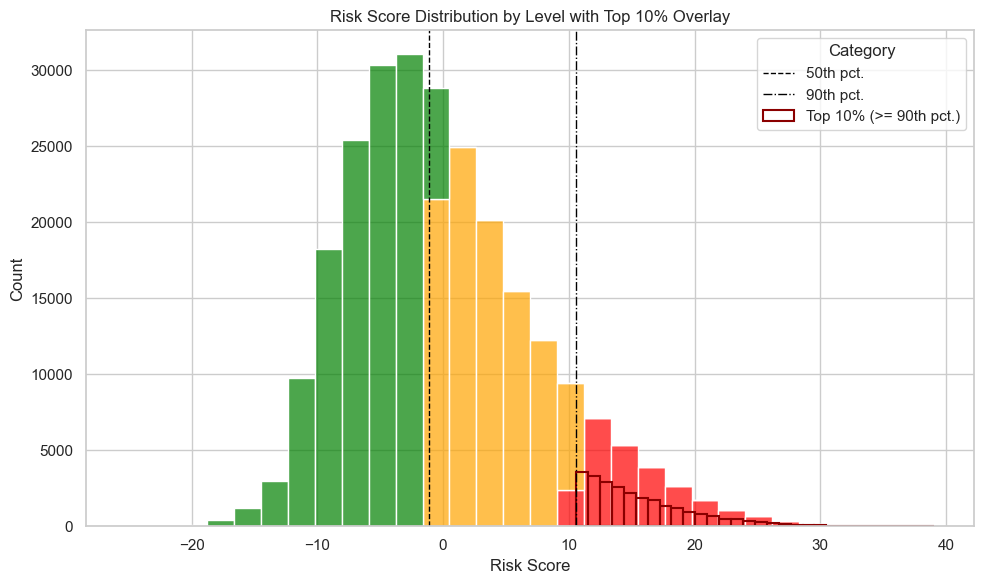

In [77]:
# ===============================
# Cell 7: Distribution with RiskLevel Bands + Top 10% Outline
# ===============================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Re-compute 90th percentile threshold (for your red outline)
threshold = df['RiskScore'].quantile(0.90)

# 2. Plot full-distribution, stacked by RiskLevel
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x='RiskScore',
    hue='RiskLevel',
    bins=30,
    palette={'Low': 'green', 'Medium': 'orange', 'High': 'red'},
    multiple='stack',
    edgecolor='w',
    alpha=0.7
)

# 3. Overlay outline of the Top 10% (High-Risk) subset
high = df[df['RiskScore'] >= threshold]['RiskScore']
sns.histplot(
    high,
    bins=30,
    color='none',
    edgecolor='darkred',
    linewidth=1.5,
    alpha=1,
    label='Top 10% (>= 90th pct.)'
)

# 4. Mark the 50th and 90th percentile cut-points
q50 = df['RiskScore'].quantile(0.50)
plt.axvline(q50,  color='black', linestyle='--', linewidth=1, label='50th pct.')
plt.axvline(threshold, color='black', linestyle='-.', linewidth=1, label='90th pct.')

# 5. Final tweaks
plt.title('Risk Score Distribution by Level with Top 10% Overlay')
plt.xlabel('Risk Score')
plt.ylabel('Count')
plt.legend(title='Category', loc='upper right')
plt.tight_layout()
plt.show()

## Step 5: High-Risk Individuals (Top 10%)


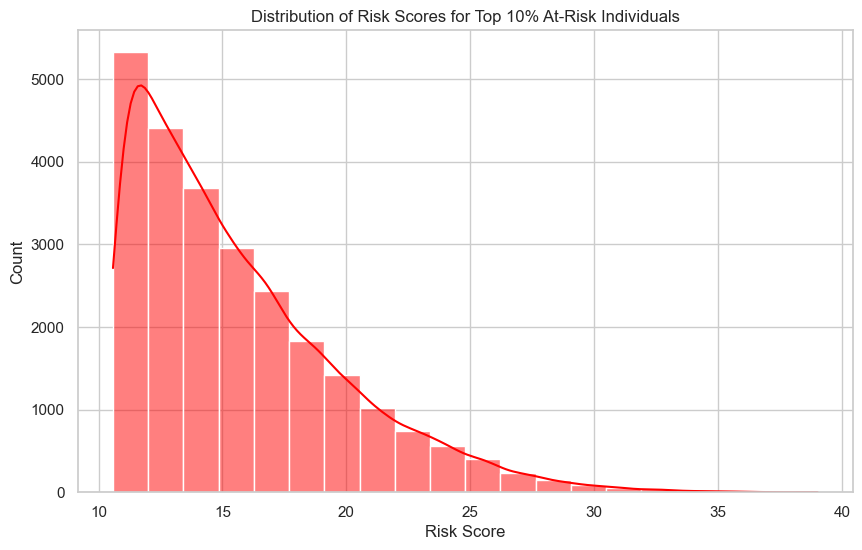

,User Reference,Diabetes Status,Risk Score,Top Risk Features
125316,User_125316,2.000000,39.015752,"PhysHlth, GenHlth, DiffWalk"
175620,User_175620,2.000000,36.843539,"PhysHlth, GenHlth, DiffWalk"
212060,User_212060,2.000000,36.378560,"PhysHlth, GenHlth, DiffWalk"
73531,User_73531,2.000000,36.135917,"PhysHlth, GenHlth, DiffWalk"
43423,User_43423,0.000000,35.630625,"PhysHlth, GenHlth, DiffWalk"
150916,User_150916,2.000000,35.504104,"PhysHlth, GenHlth, DiffWalk"
224827,User_224827,2.000000,35.490690,"PhysHlth, GenHlth, DiffWalk"
176186,User_176186,2.000000,35.418050,"PhysHlth, GenHlth, DiffWalk"
57219,User_57219,2.000000,35.319019,"PhysHlth, GenHlth, DiffWalk"
144955,User_144955,2.000000,35.117431,"PhysHlth, GenHlth, DiffWalk"


In [78]:
# ===============================
# Cell 7: High-Risk Individuals
# ===============================

# Define threshold for top 10% risk
threshold = df['RiskScore'].quantile(0.90)
high_risk_individuals = df[df['RiskScore'] >= threshold].copy()

# Define risk factors (ensure this is defined earlier in your notebook)
risk_factors = ['GenHlth', 'DiffWalk', 'PhysHlth', 'HighBP', 'HeartDiseaseorAttack']

# Function to extract top N contributing features
def top_risk_features(row, n=3):
    return ', '.join(row[risk_factors].sort_values(ascending=False).head(n).index.tolist())

# Apply feature extraction
high_risk_individuals['Top_Risk_Features'] = high_risk_individuals.apply(top_risk_features, axis=1)

# Create synthetic User Reference column
high_risk_individuals['User Reference'] = ['User_' + str(i) for i in high_risk_individuals.index]

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(high_risk_individuals['RiskScore'], bins=20, kde=True, color="red")
plt.title("Distribution of Risk Scores for Top 10% At-Risk Individuals")
plt.xlabel("Risk Score")
plt.ylabel("Count")
plt.savefig("images/high_risk_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# Display styled table of top 10 individuals
table_df = high_risk_individuals[['User Reference', target, 'RiskScore', 'Top_Risk_Features']] \
    .sort_values('RiskScore', ascending=False) \
    .head(10) \
    .rename(columns={
        target: 'Diabetes Status',
        'RiskScore': 'Risk Score',
        'Top_Risk_Features': 'Top Risk Features'
    })

table_df.style.set_caption("🔍 Top 10 High-Risk Individuals (Based on Risk Score)") \
    .background_gradient(subset=['Risk Score'], cmap='Reds') \
    .set_properties(**{'text-align': 'left'})

## Step 6: High-Risk Non-Diabetic / Pre-Diabetic Individuals


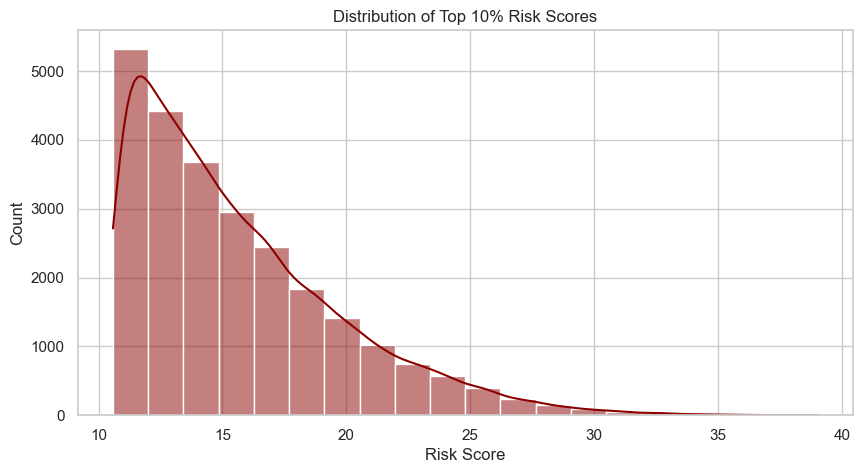

,User Reference,Risk Score,Top Risk Features
43423,User_43423,35.630625,"PhysHlth, GenHlth, DiffWalk"
206840,User_206840,34.543106,"PhysHlth, GenHlth, DiffWalk"
18802,User_18802,33.811553,"PhysHlth, GenHlth, DiffWalk"
210293,User_210293,33.661779,"PhysHlth, GenHlth, DiffWalk"
16748,User_16748,33.236955,"PhysHlth, GenHlth, HighBP"
224752,User_224752,33.078780,"PhysHlth, GenHlth, DiffWalk"
207482,User_207482,33.026138,"GenHlth, PhysHlth, DiffWalk"
1940,User_1940,32.930087,"PhysHlth, GenHlth, DiffWalk"
174831,User_174831,32.882679,"PhysHlth, GenHlth, DiffWalk"
142552,User_142552,32.771334,"PhysHlth, GenHlth, DiffWalk"


,User Reference,Risk Score,Top Risk Features
50683,User_50683,33.119712,"PhysHlth, GenHlth, DiffWalk"
229386,User_229386,32.746724,"PhysHlth, GenHlth, DiffWalk"
123617,User_123617,32.742696,"PhysHlth, GenHlth, DiffWalk"
205024,User_205024,32.106474,"PhysHlth, GenHlth, DiffWalk"
165424,User_165424,30.222184,"PhysHlth, GenHlth, DiffWalk"
95880,User_95880,28.962202,"PhysHlth, GenHlth, DiffWalk"
197210,User_197210,28.728751,"PhysHlth, GenHlth, DiffWalk"
121535,User_121535,28.297392,"PhysHlth, GenHlth, DiffWalk"
164464,User_164464,28.080656,"PhysHlth, GenHlth, DiffWalk"
203753,User_203753,27.838796,"PhysHlth, GenHlth, DiffWalk"


,User Reference,Risk Score,Top Risk Features
125316,User_125316,39.015752,"PhysHlth, GenHlth, DiffWalk"
175620,User_175620,36.843539,"PhysHlth, GenHlth, DiffWalk"
212060,User_212060,36.378560,"PhysHlth, GenHlth, DiffWalk"
73531,User_73531,36.135917,"PhysHlth, GenHlth, DiffWalk"
150916,User_150916,35.504104,"PhysHlth, GenHlth, DiffWalk"
224827,User_224827,35.490690,"PhysHlth, GenHlth, DiffWalk"
176186,User_176186,35.418050,"PhysHlth, GenHlth, DiffWalk"
57219,User_57219,35.319019,"PhysHlth, GenHlth, DiffWalk"
144955,User_144955,35.117431,"PhysHlth, GenHlth, DiffWalk"
107245,User_107245,34.970208,"PhysHlth, GenHlth, DiffWalk"


In [79]:
# ===============================
# Cell 8: Stratified High-Risk Individuals (Fast)
# ===============================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# 0. Prerequisites
target       = 'Diabetes_012'
risk_factors = ['GenHlth', 'DiffWalk', 'PhysHlth', 'HighBP', 'HeartDiseaseorAttack']

# 1. Compute 90th percentile threshold
threshold = df['RiskScore'].quantile(0.90)

# 2. Helper to build & show top-10 for one status
def show_top10(status, cmap, caption):
    # a. Filter for this status & high risk
    subset = df[(df[target] == status) & (df['RiskScore'] >= threshold)]
    if subset.empty:
        print(f"No high‐risk individuals for status {status}")
        return

    # b. Grab the top 10 rows by RiskScore
    top10 = subset.nlargest(10, 'RiskScore').copy()

    # c. Synthetic user IDs
    top10['User Reference'] = ['User_' + str(i) for i in top10.index]

    # d. Extract top-3 risk factors on just these 10 rows
    def top3(row):
        # row is a Series of only your risk_factors
        return ', '.join(row.nlargest(3).index.tolist())

    # apply to only the risk_factors columns
    top10['Top Risk Features'] = (
        top10[risk_factors]
        .apply(top3, axis=1)
    )

    # e. Build styled table
    table = (
        top10[['User Reference', 'RiskScore', 'Top Risk Features']]
        .rename(columns={'RiskScore': 'Risk Score'})
        .sort_values('Risk Score', ascending=False)
    )
    styled = (
        table.style
        .set_caption(caption)
        .background_gradient(subset=['Risk Score'], cmap=cmap)
        .set_properties(**{'text-align': 'left'})
    )
    display(styled)


# 3. Plot distribution of the Top 10% group overall
plt.figure(figsize=(10, 5))
sns.histplot(df[df['RiskScore'] >= threshold]['RiskScore'],
             bins=20, kde=True, color="darkred")
plt.title("Distribution of Top 10% Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Count")
plt.show()

# 4. Display tables by diabetes status
show_top10(0, "Oranges", "🔎 High-Risk Non-Diabetics")
show_top10(1, "Purples", "🔎 High-Risk Pre-Diabetics")
show_top10(2, "Reds",    "🔎 High-Risk Diabetics (Complication Risk)")

## Step 7: Income Analysis (4 Groups)


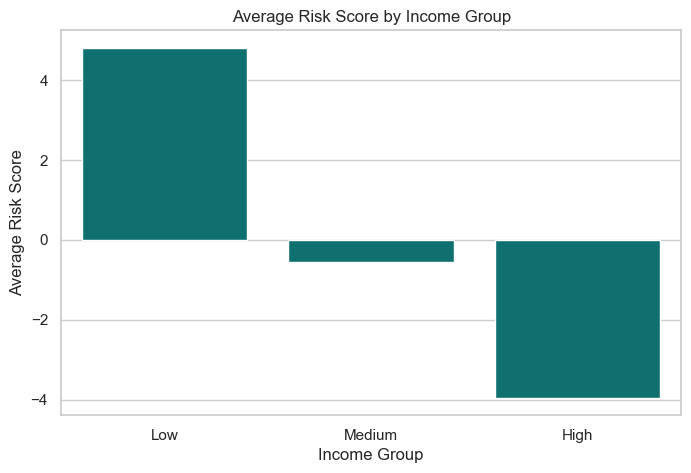

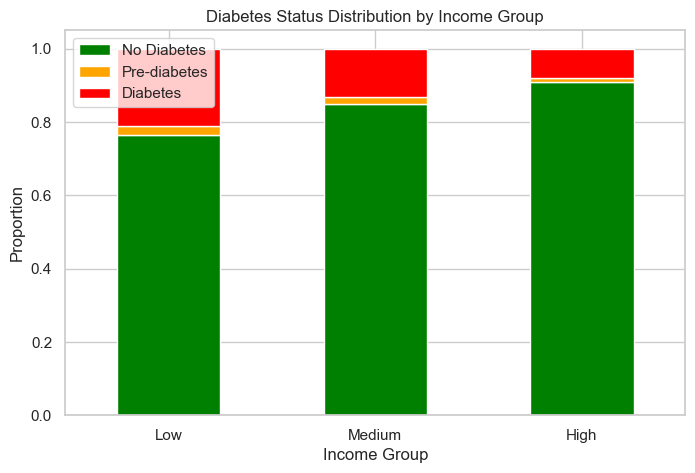

In [80]:
# ===============================
# Cell 9: Income Analysis
# ===============================
if 'Income' in df.columns:
    income_groups = pd.qcut(df['Income'], q=4, duplicates='drop')
    n_groups = income_groups.cat.categories.size
    labels = ['Low', 'Medium', 'High', 'Very High'][:n_groups]
    df['IncomeGroup'] = income_groups.cat.rename_categories(labels)
    
    # Average RiskScore by IncomeGroup
    income_risk = df.groupby('IncomeGroup')['RiskScore'].mean()
    plt.figure(figsize=(8, 5))
    sns.barplot(x=income_risk.index, y=income_risk.values, color='teal')
    plt.title("Average Risk Score by Income Group")
    plt.xlabel("Income Group")
    plt.ylabel("Average Risk Score")
    plt.savefig("images/income_risk.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Diabetes prevalence by income group
income_diabetes = df.groupby(['IncomeGroup', target]).size().unstack(fill_value=0)

# Rename columns for readability
income_diabetes.columns = ['No Diabetes', 'Pre-diabetes', 'Diabetes']

# Convert to proportions
income_diabetes_prop = income_diabetes.div(income_diabetes.sum(axis=1), axis=0)

# Plot stacked bar chart
income_diabetes_prop.plot(kind='bar', stacked=True, figsize=(8,5), color=['green','orange','red'])
plt.title("Diabetes Status Distribution by Income Group")
plt.ylabel("Proportion")
plt.xlabel("Income Group")
plt.xticks(rotation=0)
plt.savefig("images/income_diabetes_status.png", dpi=300, bbox_inches='tight')
plt.show()


## Comparing Risk vs Protective Factors
This section explores which factors contribute more to overall diabetes risk, and which are most actionable for reducing risk.



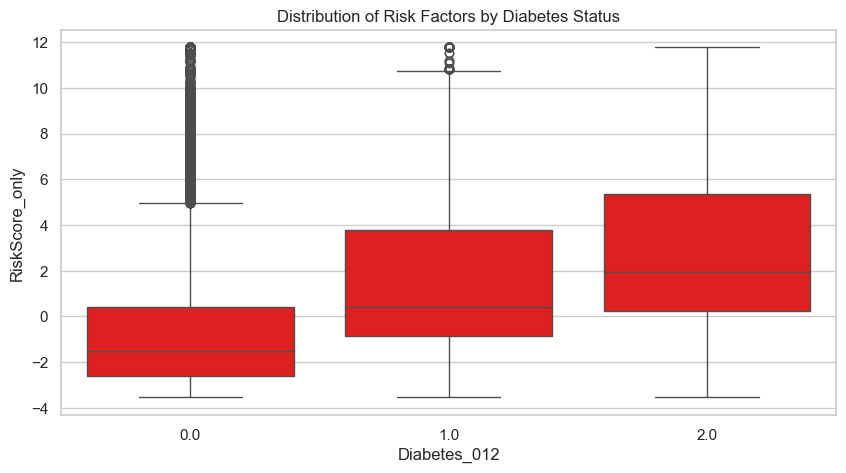

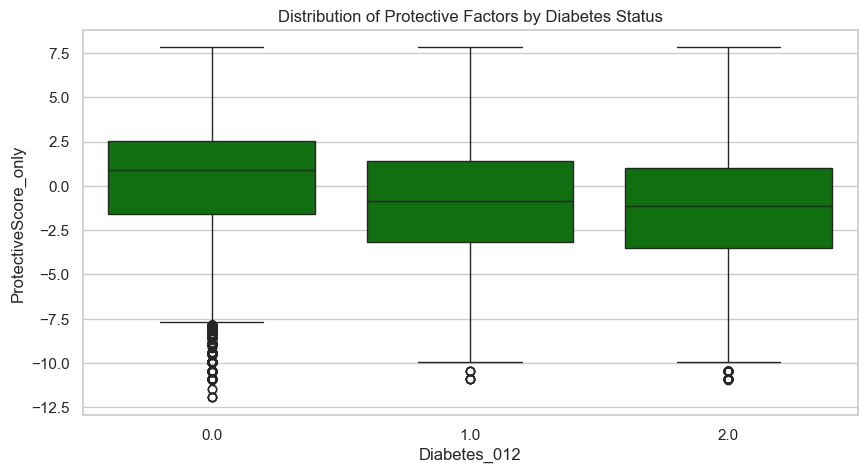

,User Reference,Risk Score Only,Income Group,Heavy Alcohol Consumption,Top Risk Features
0,User_174,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
1,User_537,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
2,User_601,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
3,User_797,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
4,User_927,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
5,User_951,11.762197,High,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
6,User_969,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
7,User_970,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
8,User_1178,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
9,User_1188,11.762197,Medium,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"


,User Reference,Risk Score Only,Income Group,Heavy Alcohol Consumption,Top Risk Features
0,User_2572,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
1,User_3919,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
2,User_5324,11.762197,Medium,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
3,User_7308,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
4,User_8696,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
5,User_13964,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
6,User_14014,11.762197,Medium,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
7,User_39651,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
8,User_41239,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"
9,User_41630,11.762197,Low,0.000000,"PhysHlth, GenHlth, HeartDiseaseorAttack"


In [81]:
# ===============================
# Boxplots + Compact Outlier Tables (Status 0 & 1) with IncomeGroup
# ===============================

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Ensure scores exist
if 'RiskScore_only' not in df.columns or 'ProtectiveScore_only' not in df.columns:
    scaler = StandardScaler()
    scaled = pd.DataFrame(
        scaler.fit_transform(df[risk_factors + protective_factors]),
        columns=risk_factors + protective_factors
    )
    df['RiskScore_only'] = scaled[risk_factors].sum(axis=1)
    df['ProtectiveScore_only'] = scaled[protective_factors].sum(axis=1)

# Ensure synthetic ID
if 'User Reference' not in df.columns:
    df['User Reference'] = ['User_' + str(i) for i in df.index]

# Ensure IncomeGroup exists
if 'Income' in df.columns and 'IncomeGroup' not in df.columns:
    income_groups = pd.qcut(df['Income'], q=4, duplicates='drop')
    n_groups = income_groups.cat.categories.size
    labels = ['Low', 'Medium', 'High', 'Very High'][:n_groups]
    df['IncomeGroup'] = income_groups.cat.rename_categories(labels)

# ===== 1. Boxplots =====
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x=target, y='RiskScore_only', color='red')
plt.title("Distribution of Risk Factors by Diabetes Status")
plt.savefig("images/risk_factors_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x=target, y='ProtectiveScore_only', color='green')
plt.title("Distribution of Protective Factors by Diabetes Status")
plt.savefig("images/protective_factors_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# ===== 2. Compact Outlier Tables =====
def top3_feats(row):
    top_idxs = row.values.argsort()[-3:][::-1]
    return ', '.join(row.index[top_idxs])

for status, label, cmap in [
    (0, "Non-Diabetic", "Oranges"),
    (1, "Pre-Diabetic", "Purples")
]:
    grp = df[df[target] == status]
    if grp.empty:
        continue

    # IQR bounds for boxplot outliers
    q1, q3 = grp['RiskScore_only'].quantile([0.25, 0.75])
    upper = q3 + 1.5 * (q3 - q1)

    # Outliers only
    outliers = grp[grp['RiskScore_only'] > upper].copy()
    if outliers.empty:
        continue

    # Keep only top N outliers
    topN = outliers.nlargest(10, 'RiskScore_only').copy()

    # Top features for these few rows
    topN['Top Risk Features'] = (
        topN[risk_factors]
        .apply(top3_feats, axis=1)
    )

    # Include IncomeGroup & HvyAlcoholConsump
    table = (
        topN[['User Reference', 'RiskScore_only', 'IncomeGroup', 'HvyAlcoholConsump', 'Top Risk Features']]
        .rename(columns={
            'RiskScore_only': 'Risk Score Only',
            'IncomeGroup': 'Income Group',
            'HvyAlcoholConsump': 'Heavy Alcohol Consumption'
        })
        .sort_values('Risk Score Only', ascending=False)
        .reset_index(drop=True)
    )

    display(
        table.style
             .set_caption(f"🛑 Top {len(table)} Outliers from Boxplot: {label} (Status {status})")
             .background_gradient(subset=['Risk Score Only'], cmap=cmap)
             .set_properties(**{'text-align': 'left'})
    )

In [82]:
# Correlation of each factor with overall RiskScore
risk_corr = df[risk_factors].corrwith(df['RiskScore']).sort_values(ascending=False)
protect_corr = df[protective_factors].corrwith(df['RiskScore']).sort_values()

# Display top contributors
print("Top Risk Factors Impacting RiskScore:")
print(risk_corr.head(5))
print("\nTop Protective Factors Impacting RiskScore:")
print(protect_corr.head(5))


Top Risk Factors Impacting RiskScore:
GenHlth                 0.671176
DiffWalk                0.585545
PhysHlth                0.550730
HighBP                  0.494741
HeartDiseaseorAttack    0.430825
dtype: float64

Top Protective Factors Impacting RiskScore:
Income         -0.507370
Education      -0.442475
PhysActivity   -0.424512
Veggies        -0.314571
Fruits         -0.276144
dtype: float64


# Key Insights (Markdown Cell)

1. Major risk factors: `AnyHealthcare`, `Sex`, `NoDocbcCost`, `Smoker`, `CholCheck`, `MentHlth`, etc.  
2. Protective factors: `Income`, `Education`, `PhysActivity`, `Veggies`, `Fruits`.  
3. Top 10% high-risk individuals are highlighted by RiskScore.  
4. Income groups show differences in diabetes risk, though some factors like lifestyle changes (e.g., physical activity, diet) are actionable to reduce personal risk.  
